### Image Mosaicking

#### Background Information
Mosaicking is an old art technique where pictures or designs are formed by inlaying small bits of colored stone, glass, or tile. These small bits are visible close up, but the boundaries of the bits will blend and a single recognizable image will show at a distance. 

In the modern digital world, this acient art form has been transformed and combined with new technologies. As one has access to large public image database, individual images, instead of pure-colored blocks can be used as tiles to make pictures. Here is a famous mosaic image of president obama (http://news.siu.edu/2009/01/011509amh9004.php) made by Anne Savage.
![Obama](http://news.siu.edu/_assets/images/2009/01/asavage_mosaic.jpg)
Nearly 6,000 images of individual faces are used to create this image. Sure enough, it has become a very popular poster because of the special art form.

It is also not hard to imagine that the process of arranging the thousands of individual picture tiles is a complex optimization problem. The target image is pre-chosen and partitioned into a grid on a blank canvas. The objective is simply choosing a small image to put on each grid so that the image resembles the target as closely as possible. In this project, we will model this optimization problem using Julia. In the first part, we present the mathematical formulation of the problem. Then we apply the theory on a very simple problem for testing purposes.  

# Common Section
Functions and Function usage examples are in the two cells that follow

In [2]:
# include common functions from a file for easier sharing across notebooks
# NOTE: CAN be edited using jupyter :)

include("./common_functions.jl")

In [4]:
# function usage examples summary
#   if you write any new functions in your code, please maintain two such cells
#   e.g. like cell above, one cell with ALL the functions
#        like this cell, a summary of all the function that you have written, with an example syntax

# image_files = get_image_files("./beer1800")
# images_mat = load_images_as_cellarray_mats(image_files)
# images = load_cellarray_mats_as_images(images_mat)
# image_mat = convert_image_to_mat(images[1])
# image = convert_mat_to_image(image_mat)

# Individual Section

My suggestion - Let's copy the code in the first two cells (common section) and do our own experiments in separate files. We can meet regularly and decide what functions that we write will be ported to the final submission and merge it accordingly.

Another suggestion - I've named this file as **main\_ananth.ipynb**. If you guys also follow the same convention (**main\_[name].ipynb**) for consistency, it would be great. Also, this way, we can name our final code as **main.ipynb** and rename it later as we see fit.

## Content below:

Last Updated: 4/23/2016
* Loading 3 image sets
* Optimizing for B/W (averaged pixel values) or RGB optimization

In [10]:
# load data

# image_files = get_image_files("./beer1800")
image_files = get_image_files("./lowres_flowers_set")
# image_files = get_image_files("./grayscale")

images_mat = load_images_as_cellarray_mats(image_files)
desired_size = (10,10)
# images_mat = subsample_cellarray_mats(images_mat, desired_size)

println(length(images_mat), " basis image files loaded")

test_image_files = get_image_files("./test_images")
test_images_mat = load_images_as_cellarray_mats(test_image_files)

println(length(test_images_mat), " test image files loaded")

test_image = test_images_mat[1]

; # to suppress display

802 basis image files loaded
1 test image files loaded


In [11]:
# series of optimization models for fixed number of images
using JuMP, Mosek

n_basis = length(images_mat)
w_basis = size(images_mat[1], 2)
h_basis = size(images_mat[1], 1)
w_test_image = size(test_image, 2)
h_test_image = size(test_image, 1)

n_basis_width = round(Int64, w_test_image/w_basis)
n_basis_height = round(Int64, h_test_image/h_basis)

# output
basis_choice = zeros(Int64, n_basis_height, n_basis_width)
mosaic_image = similar(test_image)

optimize_color = true
n_colors = nothing
basis_colors = nothing

if optimize_color
    n_colors = 3
    basis_colors = zeros(n_basis, n_colors)
    for color in 1:n_colors
        for basis in 1:n_basis
            basis_colors[basis,color] = mode(images_mat[basis][:,:,color])
        end
    end
else
    n_colors = 1
    basis_colors = zeros(n_basis, n_colors)
    for color in 1:n_colors
        for basis in 1:n_basis
            basis_colors[basis,color] = mean(images_mat[basis][:,:,:])
        end
    end
end

@showprogress 1 for j = 1:n_basis_height
    for i = 1:n_basis_width
        # pick the closest resembling basis image
        m = Model(solver = MosekSolver(LOG=1))
        @defVar(m, pick_basis[1:n_basis], Bin)
        @defVar(m, AbsMatchError[1:n_colors] >= 0)
        
        @addConstraint(m, sum(pick_basis) == 1)
        
        sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
        test_image_value = nothing
        if optimize_color
            test_image_value = [ mode(sub_test_image[:,:,color]) for color in 1:n_colors ]
        else
            test_image_value = [ mean(sub_test_image[:,:,color]) for color in 1:n_colors ]
        end
        
        @defExpr(m, MatchError[color in 1:n_colors], test_image_value[color] - sum(dot(pick_basis,basis_colors[:,color])) )
        @addConstraint(m, MatchError .<=  AbsMatchError)
        @addConstraint(m, MatchError .>= -AbsMatchError)
        
        @setObjective(m, Min, sum(AbsMatchError))
        
        status = solve(m)
        
        # show some output to communicate that things are moving forward
        
        opt_pick_basis = getValue(pick_basis)
        chosen_basis = findfirst(opt_pick_basis)
        basis_choice[j,i] = chosen_basis
        
        mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
    end
end

Progress: 100% Time: 0:00:11


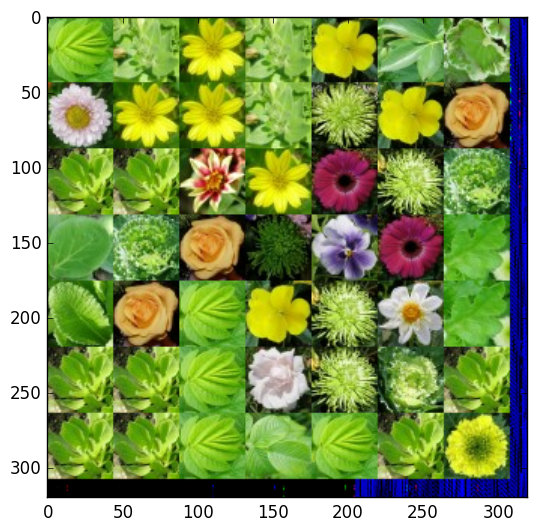

In [12]:
# check how well we did
imshow(mosaic_image);

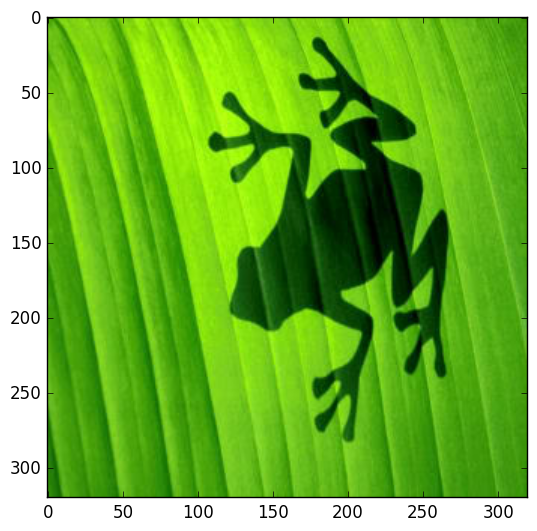

In [13]:
imshow(test_image);